# Cabbage or lettuce?

Let's build a classifier to distinguish:

- green cabbage
- iceberg lettuce
- romanesco cabbage

In [1]:
from fastai.vision.all import *

In [2]:
data_path = Path('/home/jupyter/datasets/cabbage-or-cauliflower/')

I have created 3 `.txt` files with URLs containing the 3 kinds of image

In [5]:
data_path.ls(file_exts='.txt')

(#3) [Path('/home/jupyter/datasets/cabbage-or-cauliflower/romanesco-cabbage-urls.txt'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/iceberg-lettuce-urls.txt'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage-urls.txt')]

Download files and put them into directories

In [15]:
class_names = []
for url_path in data_path.ls(file_exts='.txt'):
    file_name = url_path.name
    class_name = file_name.split('-urls.txt')[0]
    class_names.append(class_name)
    class_path = data_path/class_name
    if not class_path.exists(): class_path.mkdir()
    download_images(class_path, url_file=url_path)    

In [20]:
fns = get_image_files(data_path, folders=class_names)

In [21]:
fns

(#960) [Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000153.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000369.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000275.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000027.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000131.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000060.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000047.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000143.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000178.jpg'),Path('/home/jupyter/datasets/cabbage-or-cauliflower/green-cabbage/00000376.jpg')...]

In [22]:
failed = verify_images(fns)

In [23]:
failed

(#0) []

In [25]:
failed.map(Path.unlink);

## Create DataBlock object from data

In [34]:
get_veg_image_files = partial(get_image_files, folders=class_names)

In [35]:
veg = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # the independent and dependent variable types
    get_items=get_veg_image_files, # how to get a list of image files -- in this case from folders in the path
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # how to partition the data into training/validation sets
    get_y=parent_label, # how to get the target -- in this case from the name of the parent directory
    item_tfms=Resize(128), # transformations to apply to the data. In this case, just resize to 128x128
)

<img src="./figures/datablock.png" style="width:1000px"> 

This is the order of operations used for the DataBlock API. The Collate step loads data into mini-batches.

Dataloaders creates two loaders: one for training, one for validation.

In [36]:
dls = veg.dataloaders(data_path)

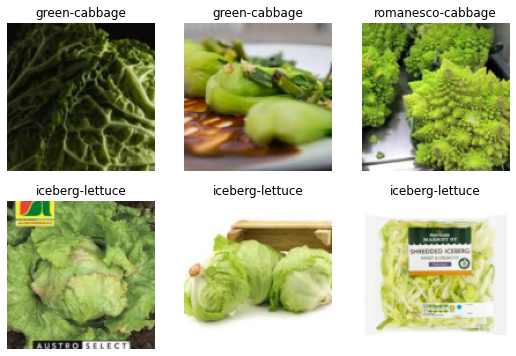

In [37]:
dls.valid.show_batch(max_n=6, nrows=2)

## Training a model

In [38]:
learn = cnn_learner(dls, resnet18, metrics=error_rate) # just train a little resnet18
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.585305,0.860146,0.322917,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.721103,0.744880,0.260417,00:01
1,0.585255,0.688195,0.239583,00:01
2,0.464427,0.713517,0.229167,00:01
3,0.386973,0.697271,0.239583,00:01


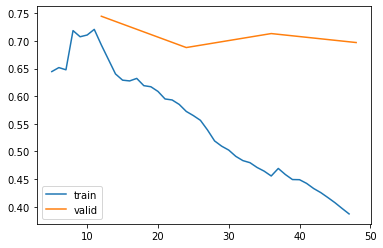

In [39]:
learn.recorder.plot_loss()

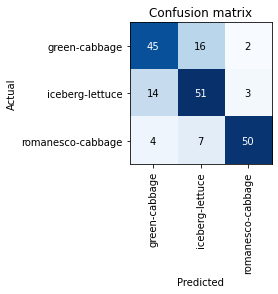

In [40]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

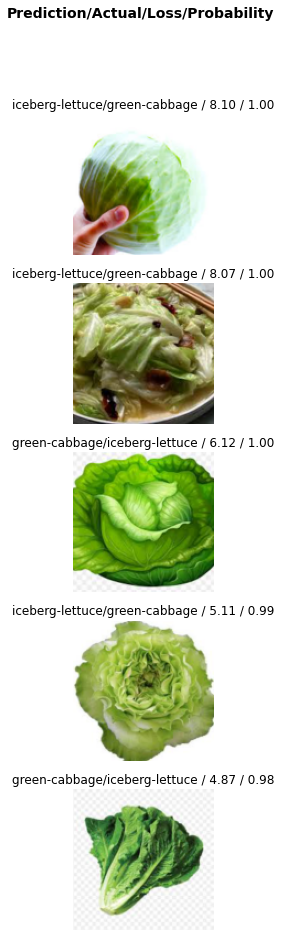

In [55]:
interp.plot_top_losses(5, nrows=5)

The images its getting wrong are either bad data or genuinely tricky cases.

## Inference time

Let's export the model, and then pretend we were using it for model inference

In [42]:
test_path = Path('./models')

In [43]:
learn.export(fname=test_path/'veg.pkl')

In [45]:
learner_inf = load_learner(test_path/'veg.pkl')

In [47]:
test_images = data_path.ls(file_exts='.jpg')

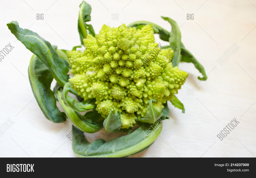

In [48]:
Image.open(test_images[0]).to_thumb(256,256)

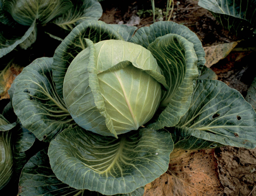

In [49]:
Image.open(test_images[1]).to_thumb(256,256)

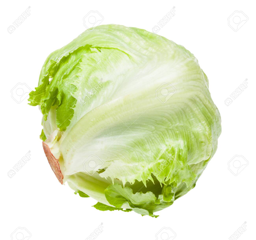

In [50]:
Image.open(test_images[2]).to_thumb(256,256)

In [51]:
learner_inf.predict(test_images[0])

('romanesco-cabbage', tensor(2), tensor([3.1129e-09, 7.0405e-07, 1.0000e+00]))

In [52]:
learner_inf.predict(test_images[1])

('green-cabbage', tensor(0), tensor([9.9999e-01, 2.4305e-06, 1.2240e-05]))

In [53]:
learner_inf.predict(test_images[2])

('iceberg-lettuce', tensor(1), tensor([2.5811e-05, 9.9997e-01, 1.3195e-06]))

In [54]:
learner_inf.dls.vocab

(#3) ['green-cabbage','iceberg-lettuce','romanesco-cabbage']

So the model works pretty well, at least for clear cases.